In [1]:
print('Loading modules....')

import os, sys


import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import ROOT as rt
#import seaborn as sns
import operator as op
import pandas as pd
#from collections import Counter

print('modules loaded...')

Loading modules....


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject
/usr/local/lib/python3.8/dist-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
/data/chocula/test_cdmsbats/root_install/lib/cppyy/__init__.py:72: DeprecationWarning: invalid escape sequence \d
  if re.match('^libcppyy_backend\d_\d$', lib_name):


Welcome to JupyROOT 6.24/06
modules loaded...


In [2]:
os.path.exists("/data/chocula/robbtanner/usr/local/bin/r79-noisefiles")

True

In [3]:
import cdms

In [4]:
#series = ['23231219_184002']
series=['07240206_1402']
#event_numbers = [42499, 110523, 200199, 203569, 203576, 263548, 322159, 333501, 340031, 340043] #for Z1
event_numbers=[2260100.0]
#event_numbers = [42778, 60675, 61585, 102412, 111229, 150793, 152887, 190538, 193667, 221976] #for Z3
det = 'Z1'
detNum = int(det[-1])

## Load RQ related quantities

In [5]:
#base = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2./Submerged'
base = '/data/chocula/spa-u-cdmssoft/rq'
file_prefix = 'CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2.'
# if(dataset == 'prompt'):
#     base = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged'
#     file_prefix = 'Prompt_V04-15_P0.2.1'
dets = ['Z1']

filePath = []
found_series = []
for ser in series:
    
    #fp = '%s/%s_%s.root'%(base,file_prefix,ser)
    fp = '%s/%s/umn_%s_10Dumps.root'%(base,ser,ser)
    if(os.path.exists(fp)):
        print(ser,' : ',fp)
        filePath.append(fp)
        found_series.append(ser)
    else:
        print('not found: ',fp)
series = found_series
print('Found series = ',series)


print('Loading RQ and Event Tree...')
RQ=[]
"""
for i,ser in enumerate(series):
    RQ.append(uproot.open(filePath[i])['rqDir/zip%d'%(detNum)]) 
"""
zips = {
    'Z1' : 'zip1',
    'Z2' : 'zip2',
    'Z3' : 'zip3',
    'Z4' : 'zip4',
    'Z5' : 'zip5',
    'Z6' : 'zip6'
}
for idx,key in enumerate(series):
    t = {}
    for i,det in enumerate(dets):
        t[det] = uproot.open(filePath[idx])['rqDir/%s'%(zips[det])]
    RQ.append(t)

eventTree=[]
for i,ser in enumerate(series):
    eventTree.append(uproot.open(filePath[i])['rqDir/eventTree']) 

print('done..')


print('Loading OF spefic data....')
#Load RQs from processed files
#channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
channels = ['PA','PB','PC','PD','PF']#,'PT']

OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
OFbs={}

for i,key in enumerate(series): # for each series
    ta={}
    ta0={}
    tc={}
    tnorm={}
    tbs={}
    td={}
    for j,det in enumerate(dets):     # for each detector
        tta={}
        tta0={}
        ttc={}
        ttnorm={}
        ttbs={}
        ttd={}
#        ttwf40={}
#        ttwr40={}
#        ttwr100={}
#        ttwr20={}
#        ttwf80={}
#        ttwr80={}
#        ttwr50={}
#        ttwf20={}
        
        print('Detector = ',det)
        for c in channels:                # for each channel
            
#             if(det == 'Z3' and c == 'PAS1'):
#                 print('\tSkipping Z3-PAS1...')
#                 continue
            #print('\t chan = ',c)
            tta[c]=(RQ[i][det][c+"OFamps"].array(library='np'))
            tta0[c]=(RQ[i][det][c+"OFamps0"].array(library='np'))
            ttc[c]=(RQ[i][det][c+"OFchisq"].array(library='np'))
            ttnorm[c]=(RQ[i][det][c+"norm"].array(library='np'))
            ttd[c]=(RQ[i][det][c+"OFdelay"].array(library='np'))
            
#             tta[c]=(RQ[i][det].array(c+"OFamps"))
#             tta0[c]=(RQ[i][det].array(c+"OFamps0"))
#             ttc[c]=(RQ[i][det].array(c+"OFchisq"))
#             ttint[c]=(RQ[i][det].array(c+"INTall"))
#             ttd[c]=(RQ[i][det].array(c+"OFdelay"))
#             ttwf40[c]=(RQ[i][det].array(c+"WKf40"))
#             ttwr40[c]=(RQ[i][det].array(c+"WKr40"))
#             ttwr20[c]=(RQ[i][det].array(c+"WKr20"))           
            if(c!='PT'):
                #ttbs[c]=(RQ[i][det].array(c+"bs"))
                ttbs[c]=(RQ[i][det][c+"bs"].array(library='np'))
        
        ta[det] = tta
        ta0[det] = tta0
        tc[det] = ttc
        tnorm[det] = ttnorm
        td[det] = ttd
        tbs[det] = ttbs
    
    OFamps[key]=ta
    OFamps0[key]=ta0
    OFchiq[key]=tc
    OFnorms[key]=tnorm
    OFdelay[key]=td
    OFbs[key]=tbs
    
        
    print('Done for %s..'%(key))
"""
for i,key in enumerate(series):
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for c in channels:
        if(detNum == '3' and c == 'PAS1'):
            print('\tSkipping Z3-PAS1...')
            continue
        tc[c]=(RQ[i].array(c+"OFchisq"))
        ta[c]=(RQ[i].array(c+"OFamps"))
        ta0[c]=(RQ[i].array(c+"OFamps0"))
        td[c]=(RQ[i].array(c+"OFdelay"))
        if(c!='PT'):
            tn[c] = (RQ[i].array(c+"norm"))
            tbs[c] = (RQ[i].array(c+"bs"))
    OFchiq[key]=tc
    OFamps[key]=ta
    OFamps0[key]=ta0
    OFdelay[key]=td
    OFnorms[key]=tn
    OFbs[key]=tbs
    print('%s loaded'%(key))
"""
print('done!')

print(' Loading Event specific data....')


TriggerTime=[] # Can't find it in UMN event tree. Luckily never used.
TriggerType=[] # Same here...
EventNumber=[]
TrigDet=[] # And here...
TriggerMask=[] # And here.
EventTime=[]

R2 = {} # Radial parameter for S2
R1 = {} # Radial parameter for S1
amp_diff = {}  
amp_diff_abs = {}
for i,key in enumerate(series):
    #TriggerTime.append(eventTree[i]["TriggerTime"].array())#eventTree[i].array("TriggerTime"))
    #TriggerType.append(eventTree[i]["TriggerType"].array())#eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i]["EventNumber"].array())#eventTree[i].array("EventNumber"))
    #TrigDet.append(eventTree[i]["TriggerDetectorNum"].array())#eventTree[i].array("TriggerDetectorNum"))
    #TriggerMask.append(eventTree[i]["TriggerMask"].array())#eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i]["EventTime"].array())#eventTree[i].array("EventTime"))
    #R2[key] = OFdelay[key]['PFS2'] - OFdelay[key]['PAS2']
    #R1[key] = OFdelay[key]['PFS1'] - OFdelay[key]['PAS1']
    #amp_diff[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])/(OFamps[key]['PFS2'] + OFamps[key]['PAS2'])
    #amp_diff_abs[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])
    print('%s loaded'%(key))

print('Done!')
#/data/chocula/spa-u-cdmssoft/rq/07240206_1402

07240206_1402  :  /data/chocula/spa-u-cdmssoft/rq/07240206_1402/umn_07240206_1402_10Dumps.root
Found series =  ['07240206_1402']
Loading RQ and Event Tree...
done..
Loading OF spefic data....
Detector =  Z1
Done for 07240206_1402..
done!
 Loading Event specific data....
07240206_1402 loaded
Done!


In [6]:
'''
    Load  OFamps, baseline, and delay for specific events
'''

proc_of = {}
proc_bs = {}
proc_delay = {}

for idx, key in enumerate(series):
    t_of = []
    t_bs = []
    t_delay = []
    for j,det in enumerate(dets):
        for enum in event_numbers:
            tt_of = {}
            tt_bs = {}
            tt_delay = {}
            for c in channels:
                if(c != 'PT'):
                    tt_bs[c] = ((OFbs[key][det][c][EventNumber[idx] == enum]))
                tt_of[c] = ((OFamps[key][det][c][EventNumber[idx] == enum]))
            
                tt_delay[c] = ((OFdelay[key][det][c][EventNumber[idx] == enum]))
            t_of.append(tt_of)
            t_bs.append(tt_bs)
            t_delay.append(tt_delay)
    proc_of[key] = t_of
    proc_bs[key] = t_bs
    proc_delay[key] = t_delay
print('done')

done


In [7]:
EventNumber[0][0]

2260000.0

In [8]:
OFbs['07240206_1402']

{'Z1': {'PA': array([7911.91836735, 7898.06122449, 7899.4744898 , ..., 7921.25765306,
         7915.72193878, 7915.98214286]),
  'PB': array([5649.3622449 , 5634.43877551, 5635.19642857, ..., 5661.57397959,
         5656.20663265, 5656.17602041]),
  'PC': array([2911.18367347, 2888.22193878, 2888.2627551 , ..., 2921.47959184,
         2916.85714286, 2915.2755102 ]),
  'PD': array([8147.11989796, 8131.78061224, 8132.94132653, ..., 8163.21938776,
         8155.96938776, 8157.16836735]),
  'PF': array([6194.93112245, 6182.99744898, 6182.50510204, ..., 6208.33928571,
         6204.86479592, 6203.85204082])}}

## Load Noise file to get templates

In [9]:
'''
    Get noise info from BatNoise file
'''
zips = {
    'Z1' : 'zip1',
    'Z2' : 'zip2',
    'Z3' : 'zip3',
    'Z4' : 'zip4',
    'Z5' : 'zip5',
    'Z6' : 'zip6'
}
noisebase="/data/chocula/robbtanner/usr/local/bin/r79-noisefiles" #my kernel doesn't see spa-u-cdmssoft :(
#noisebase="/home/spa-u-cdmssoft/noisefiles"
noisefile_prefix="umn_Filter"
#umn_Filter_07240206_1402.root
#noisebase = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2./Noise'
#noisefile_prefix = 'CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2._Filter'
import os
print(os.path.exists("/home/spa-u-cdmssoft"))

noisefile = []
for i,key in enumerate(series):
    path = '%s/%s_%s.root'%(noisebase,noisefile_prefix,key)
    file = rt.TFile.Open(path)
    if(not file):
        print('Couldnt open %s'%(path))
    noisefile.append(file)    

print('Files loaded...')

template_hist = {}
for i, key in enumerate(series):
    th = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        temp = noisefile[i].Get('%s/%sTemplateTime'%(zips[det],c))
        if(not temp):
            print('NULL for %s : %s'%(key,c))
        th[c] = temp
    template_hist[key] = th
print('Templates laoded as histograms...')

template = {}
for i, key in enumerate(series):
    tarr = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        bincenter = []
        bincontent = []
        #bincontent = [temp.GetBinContent(j) for j in temp.GetNbinsX()]
        temp = template_hist[key][c]
        for j in range(temp.GetNbinsX()):
            bincenter.append(temp.GetBinCenter(j))
            bincontent.append(temp.GetBinContent(j))
        tarr[c] = bincontent
    template[key] = tarr

print('Templates loaded as dict...')

False
Files loaded...
Templates laoded as histograms...
Templates loaded as dict...


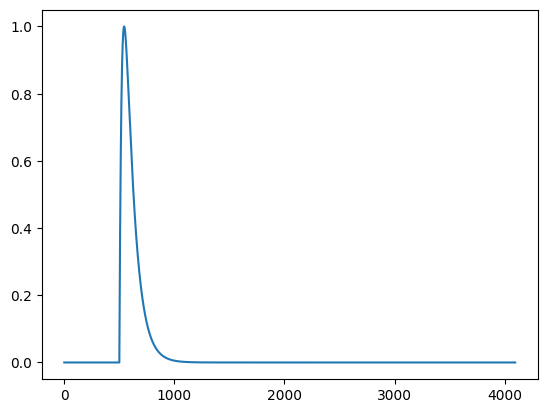

In [17]:
plt.plot(template['07240206_1402']["PB"])

## Load raw traces
* Change the values in the cell below accroding to the detector (UMN detectors have different settings)

In [10]:
Rshunt = 5.0e-3 # shunt resistance
Rfb = 5000.0 # feedback resistance
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout
LoopRatio = 2.4 # SQUID turn ratio 
low_pass_filter = False
high_cutoff, fs, order = 100000, 625000, 2
trace_length = 1.6 # uS
bins = 32768
rawfilepath="/data/chocula/fritts/data/k100proc/midasraw/byseries"#'/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/'
channels = ['PA','PB','PC','PD',"PF"]#,'PT'
#channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']
#"/data/chocula/fritts/data/k100proc/midasraw/byseries/07240206_1402"

In [22]:
nSamples=4096
time = np.arange(nSamples,dtype=np.float64)
sf = 1.25e6
samplelength = 1/sf
time2 = time*samplelength
ADCperVolt = 16384./2.5
LoopGain = 10000 # Phonon feeback gain (=10 (input/fb turn ratio) * 1000 Ohm fb resistor)
DG = 20 # driver gain
scale = ADCperVolt*LoopGain

In [12]:
#x=cdms.rawio.IO.RawDataReader(rawfilepath,"07240206_1402",verbose=False).read_events(dump_nums=1,output_format=2)

In [13]:
#y=cdms.rawio.IO.RawDataReader(rawfilepath,"07240206_1402",verbose=False).read_events_info(dump_nums=1)

In [14]:
"""for i in range(len(y)):
    good=False
    for j in range(len(x)):
        if y[i]["event"]["EventNumber"]==x[j]["event"]["EventNumber"]:
            good=True
    if not good:
        print("BAD:",i,y[i]["event"]["EventNumber"])"""

'for i in range(len(y)):\n    good=False\n    for j in range(len(x)):\n        if y[i]["event"]["EventNumber"]==x[j]["event"]["EventNumber"]:\n            good=True\n    if not good:\n        print("BAD:",i,y[i]["event"]["EventNumber"])'

In [15]:
"""for i in range(2170,2180):
    if i==2175:
        print("qwerty",end="")
    print(y[i]["trigger_veto"]["Z5"]["ReadoutStatus"])"""

'for i in range(2170,2180):\n    if i==2175:\n        print("qwerty",end="")\n    print(y[i]["trigger_veto"]["Z5"]["ReadoutStatus"])'

In [19]:
channel_mappings={"PA":["Z3","PB"],"PB":["Z3","PA"],"PC":["Z1","PA"],"PD":["Z3","PD"],"PF":["Z1","PB"]}

In [18]:
#y["event"]["EventNumber"]
# Channel -> Event Number -> Pulse
dumps_list=list(range(51,100))
import time
raw_data={"PA":{},"PB":{},"PC":{},"PD":{},"PE":{},"PF":{}}
series="07240206_1402"
#fname = './rawdata/%s_raw_data_51_to_100'%(series)
#print("Loading saved data...")
#with open(fname+"_50.pkl","rb") as f:
#    raw_data=pkl.load(f)
dump_data=cdms.rawio.IO.RawDataReader(rawfilepath,series,verbose=False).read_events(event_nums=2260790,output_format=2,skip_empty=True)
"""start_time=time.time()
pickle_time=start_time
last_pickled_dump=0
warn_num=0
for i,dump in enumerate(dumps_list):
    print("Processing Dump",dump)
    last_time=int(time.time())
    dump_data=cdms.rawio.IO.RawDataReader(rawfilepath,series,verbose=False).read_events(dump_nums=dump,output_format=2)
    print("Data Read! Entering into dictionary...")
    for event in dump_data:
        if event["event"]["EventNumber"] in raw_data["PA"].keys():
            if warn_num<20:
                print("Warning: event number",event["event"]["EventNumber"],"is getting overwritten!")
            elif warn_num==20:
                print("Supressing further warnings.")
            warn_num+=1
        for key in channel_mappings:
            raw_data[key][event["event"]["EventNumber"]]=event[channel_mappings[key][0]][channel_mappings[key][1]]
    print("Entered!")
    
    if (time.time()-pickle_time)>10*60:
        print("10 minutes since last pickle dump. Dumping...")
        with open(fname+"_"+str(dump)+".pkl","wb") as f:
            pkl.dump(raw_data, f)
        pickle_time=time.time()
        last_pickled_dump=dump
    
    print("Done! This dump took",int(time.time())-last_time,"seconds. Expect this process to finish in"\
          ,round((1/60)*(time.time()-start_time)/(i+1)*(len(dumps_list)-i-1),1),"minutes.\nThe last pickled dump is dump",last_pickled_dump)
print("Done! Finished with",warn_num,"warnings. Saving Pickle...")
with open(fname+".pkl","wb") as f:
    pkl.dump(raw_data, f)
print("Done.")"""
print("",end="")

The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries/07240206_1402/07240206_1402_F0226.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries/07240206_1402/07240206_1402_F0226.mid.gz


In [17]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False
def eventShift(pdir=rawfilepath,s=series,ev=None):

    dumps=(ev-ev%10000)/10000
    dumps=dumps.astype(int)
    udumps=np.unique(dumps)
    print(udumps)

    dumpdict=dict()

    for d in udumps:
        theseev = np.sort(ev[dumps==d])
        dumpdict[d]=theseev
        #make an event number vector that has all events up to the max
        fullev=[]
        #for i in np.arange(d*10000,d*10000+9999):
        #for i in np.arange(d*10000,np.max(theseev)+1):
        #    fullev.extend([i])

        #print(fullev)
        #events=io.getRawEvents(pdir,series,eventNumbers=fullev)
        myreader = cdms.rawio.IO.RawDataReader(filepath=pdir, series=s) 
        events =  myreader.read_events(dump_nums=[d], output_format=2, skip_empty=True)
        railed=[]
        #for oneev in events:
        #    fullev.append(oneev["event"]["EventNumber"])
        
        print(dumpdict)
        for oneev in events:
            #intseries=np.char.replace(series,'_','')
            #intseries=int(intseries)
            #print(intseries)
            #print(events['Z1']['PA'][intseries,j])
            if isRailed(oneev['Z1']['PA']):
                railed.extend([j])

        railed=np.asarray(railed)
        print(np.shape(railed)) 
        shifts=[]
        for e in theseev:
            shifts.extend([np.sum(railed<=e)])

        print(shifts)

In [18]:
eventShift(ev=np.array([2260790]))

[226]
INFO: Found 241 midas raw data files
INFO: Found 1 midas raw data files
{226: array([2260790])}
(0,)
[0]
The file is: /data/chocula/fritts/data/k100proc/midasraw/byseries/07240206_1402/07240206_1402_F0226.mid.gz

Opened raw midas file: /data/chocula/fritts/data/k100proc/midasraw/byseries/07240206_1402/07240206_1402_F0226.mid.gz


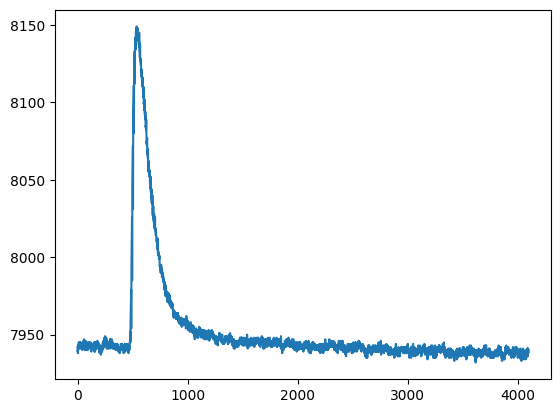

In [20]:
plt.plot(dump_data[0]["Z3"]["PB"])

In [19]:
d={"a":1,"b":2}
"a" in d.keys()

True

In [15]:
channel_mappings={"PA":["Z3","PB"],"PB":["Z3","PA"],"PC":["Z1","PA"],"PD":["Z3","PD"],"PE":None,"PF":["Z1","PB"]}

In [16]:
raw_directory="./rawdata/"
for key in channel_mappings:
    print(k)

PA
PB
PC
PD
PE
PF


Text(0.5, 1.0, 'Example Event, series=07240206_1402, dump number=124')

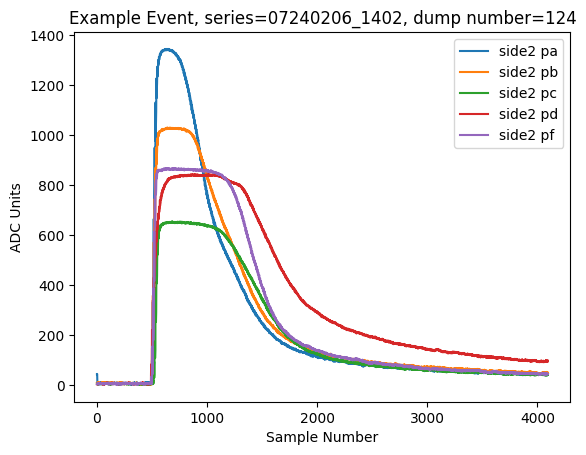

In [13]:
i=3
plt.plot(x["Z3"]["PB"].array[i]-np.min(x["Z3"]["PB"].array[i]),alpha=1,label="side2 pa")
plt.plot(x["Z3"]["PA"].array[i]-np.min(x["Z3"]["PA"].array[i]),alpha=1,label="side2 pb")
plt.plot(x["Z1"]["PA"].array[i]-np.min(x["Z1"]["PA"].array[i]),alpha=1,label="side2 pc")
plt.plot(x["Z3"]["PD"].array[i]-np.min(x["Z3"]["PD"].array[i]),alpha=1,label="side2 pd")
plt.plot(x["Z1"]["PB"].array[i]-np.min(x["Z1"]["PB"].array[i]),alpha=1,label="side2 pf")

#plt.plot(x["Z1"]["PC"].array[i]-np.median(x["Z1"]["PC"].array[i]),alpha=1,label="side1 pc")
#plt.plot(x["Z1"]["PD"].array[i]-np.median(x["Z1"]["PD"].array[i]),alpha=1,label="side1 pd")
#plt.plot(x["Z3"]["PC"].array[i]-np.median(x["Z3"]["PC"].array[i]),alpha=1,label="side1 pb")

#plt.plot(x["Z1"]["QI"].array[i]-np.median(x["Z1"]["QI"].array[i]),alpha=0.5,label="QI subracted by its median")
#plt.plot(x["Z1"]["QO"].array[i]-np.median(x["Z1"]["QO"].array[i]),alpha=0.5,label="QO subracted by its median")
plt.legend()
plt.ylabel("ADC Units")
plt.xlabel("Sample Number")
plt.title("Example Event, series=07240206_1402, dump number=124")
#plt.plot(x["Z1"]["PF"].array[3]-np.median(x["Z1"]["PF"].array[3]))
#np.median(x["Z1"]["QO"].array[i])

### Make sure to create a `rawdata` directory. The pulses will be dumped to this directory in pickle format so that you don't have to load the data from midas file again and again which takes time.

In [48]:
nSamples=4096
time = np.arange(nSamples,dtype=np.float64)
sf = 1.25e6
samplelength = 1/sf
time2 = time*samplelength
ADCperVolt = 16384./2.5
LoopGain = 10000 # Phonon feeback gain (=10 (input/fb turn ratio) * 1000 Ohm fb resistor)
DG = 20 # driver gain
scale = ADCperVolt*LoopGain
bins = 4096

In [24]:

data = {}
raw_data = {}
for idx, key in enumerate(series):
    c = 'PT'
    t_rd = {}
    
    for c in channels:
        fname = './rawdata/%s_%s_%s_1kev_elliott.pkl'%(key,det,c)
        if(c=='PT'):
            continue
        #event_number[c] = EventNumber[idx][cut][:10]
        if(det == 'Z3' and c == 'PAS1'):
            continue
        if os.path.exists(fname):
            t_rd[c] = pkl.load(open(fname, "rb"))
            print('pkl file loaded for %s'%(c))
        else:
            print('No pickle file available. Loading traces... ')
            
            t_rd[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+key,outputFormat = 2, eventNumbers=event_numbers, 
                                                   channelList=[c], detectorList=[detNum], verbose=True)
            pkl.dump(t_rd[c], open(fname, "wb"))
            
            print('pkl file loaded for %s'%(c))
    raw_data[key] = t_rd
    print('Raw traces [ADC] loaded...')
    



No pickle file available. Loading traces... 


ValueError: ERROR: No midas raw data files found!

In [41]:
series = ['07240206_1402']

In [56]:
'''
    Convert traces from ADC to uA
'''
raw_data=dump_data
data = {}
detNum = int(det[-1])
adc2ua = {}
det = 'Z3'
for idx, key in enumerate(series):
    print('Now converting into amps...')
    t_adc2uA = {}
    t_d = {}
    t_rd = raw_data[idx]
    print(idx)
    for c in channels:
        if(c=='PT' or c=='PF'):
            continue
        
        temp = []
        #DriverGain = dsettings[key][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DG*LoopGain*ADCperVolt) #Convert detector parameters to amplitude for trace
        t_adc2uA[c] = conv2Amps
        
        for i in range(len(t_rd[det][c])):
            temp.append(((t_rd)[det][c])*conv2Amps)
        t_d[c] = temp
    data[key] = t_d
    adc2ua[key] = t_adc2uA
    
    print('-------- %s : Traces coverted to Amps for channel -------------'%(key))
print('all done')

Now converting into amps...
0
-------- 07240206_1402 : Traces coverted to Amps for channel -------------
all done


In [57]:
(series[0])

'07240206_1402'

In [58]:
adc2ua

{'07240206_1402': {'PA': 1.52587890625e-13,
  'PB': 1.52587890625e-13,
  'PC': 1.52587890625e-13,
  'PD': 1.52587890625e-13}}

In [59]:
dump_data[0]['Z1']

{'QI': array([32226, 32226, 32225, 32225, 32225, 32221, 32223, 32220, 32224,
        32227, 32227, 32224, 32222, 32227, 32227, 32220, 32227, 32223,
        32226, 32220, 32225, 32231, 32225, 32222, 32225, 32219, 32231,
        32220, 32227, 32224, 32225, 32224, 32222, 32227, 32224, 32225,
        32225, 32225, 32228, 32223, 32219, 32222, 32225, 32224, 32222,
        32227, 32219, 32223, 32222, 32222, 32225, 32226, 32220, 32224,
        32227, 32223, 32222, 32223, 32225, 32223, 32222, 32221, 32227,
        32230], dtype=uint16),
 'QO': array([33386, 33386, 33384, 33379, 33383, 33383, 33381, 33379, 33388,
        33386, 33383, 33383, 33374, 33380, 33386, 33381, 33385, 33381,
        33382, 33376, 33383, 33388, 33384, 33382, 33383, 33372, 33393,
        33374, 33383, 33381, 33382, 33386, 33386, 33383, 33384, 33389,
        33387, 33388, 33389, 33383, 33381, 33382, 33381, 33385, 33380,
        33389, 33378, 33384, 33385, 33384, 33386, 33388, 33383, 33382,
        33385, 33385, 33386, 33382

In [60]:

'''
  Compute pedestal subtracted traces
'''

traces_ped_sub = {}
for idx, key in enumerate(series):
    t = {}
    for c in channels:
        if(c == 'PT'  or c=='PF'):
            continue
        if(det=='Z3' and c == 'PAS1'):
            continue
        tt = []
        for i in range(len(event_numbers)):
            pedestal = proc_bs[key][i][c][0] * adc2ua[key][c]
            #ttt = data[key][c][i] - pedestal
            tt.append(data[key][c][i] - pedestal)
        t[c] = tt
    traces_ped_sub[key] = t
print('Done')

Done


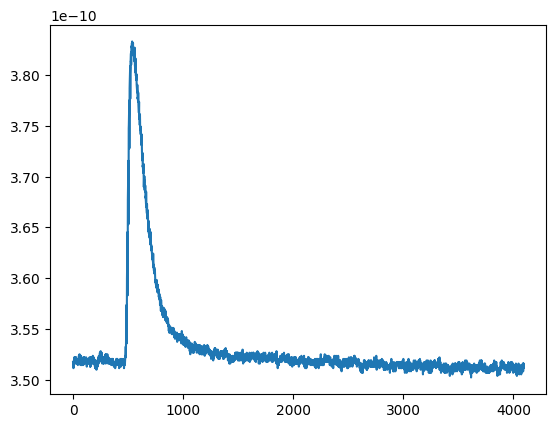

In [61]:
plt.plot(traces_ped_sub['07240206_1402']["PB"][0])

In [62]:
'''
    Construct PT traces
'''


for idx, key in enumerate(series):
    
    tt = []
    for i in range(len(event_numbers)):
        t = np.zeros(bins)
        for c in channels:
            if(c == 'PT'  or c=='PF'):
                continue
            if(det=='Z3' and c=='PAS1'):
                continue
            t += traces_ped_sub[key][c][i]
        tt.append(t)
    
    traces_ped_sub[key]['PT'] = tt
print('Done')

Done


In [63]:
'''
    compute template for each event, each channel : time-shifted, scaled by ofamp
'''

template_ss = {} # per series , per channel, per event
for idx, key in enumerate(series):
    t = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        tt = []
        for i in range(len(event_numbers)):
            shift = int((proc_delay[key][i][c]*1e6)/trace_length)
            scale = proc_of[key][i][c]
            ttt = np.array(template[key][c])
            ttt = np.roll(ttt,shift)
            ttt *= scale
            tt.append(ttt)
        t[c] = tt
    template_ss[key] = t

print('done!')

done!


In [64]:
'''
    Low pass filter
'''

import scipy.optimize as optimize
from scipy.signal import firwin, lfilter
def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
    # Calculate the Nyquist frequency
    nyquist_frequency = 0.5 * sampling_rate

    # Normalize the cutoff frequency
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design a low-pass FIR filter
    filter_coefficients = firwin(filter_order, normalized_cutoff, window='hamming')

    # Apply the filter to the signal using lfilter
    filtered_signal = lfilter(filter_coefficients, 1.0, signal)

    return filtered_signal


In [65]:
'''
    Cosmetics
'''

color_p = {
    'PA' : 'red',
    'PB' : 'orange',
    'PC' : 'brown',
    'PD' : 'blue',
    'PE' : 'cyan',
    'PF' : 'green',
    'PAS2' : 'red',
    'PBS2' : 'orange',
    'PCS2' : 'brown',
    'PDS2' : 'blue',
    'PES2' : 'cyan',
    'PFS2' : 'green',
    'PT'   : 'black'
    
}
style_p = {
    'PA' : '-',
    'PB' : '-',
    'PC' : '-',
    'PD' : '-',
    'PE' : '-',
    'PF' : '-',
    'PAS2' : '--',
    'PBS2' : '--',
    'PCS2' : '--',
    'PDS2' : '--',
    'PES2' : '--',
    'PFS2' : '--',
    'PT'   : '-'
}
# cycler = plt.cycler(linestyle=['-', '-', '-', '-', '-', '-', '--','--','--','--','--','--'],
#                     color=['maroon', 'orange', 'yellow', 'black', 'blue', 'green', 'maroon', 'orange', 'yellow', 'black', 'blue', 'green'],
# )

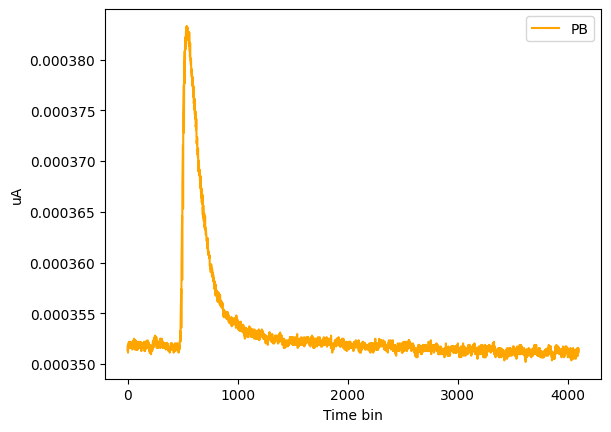

In [76]:

idx = 0
high_cutoff, fs, order = 1000, 125000, 1
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
#     if(c=='PT'):
#         continue
    if(c!='PB'):
         continue

    if(det == 'Z3' and c == 'PAS1'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    #lp_filtered = (bs_corrected)
    
    plt.plot((lp_filtered)*1e6,label=c,color=color_p[c],linestyle=style_p[c])
    #plt.title(key+', '+det+', event #%d'%(raw_data[key]['PA'][idx]['event']['EventNumber']))
plt.legend()
#plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
plt.xlabel('Time bin')
#plt.ylim(-0.02,0.14)
plt.show()

9.114887841901639e-07


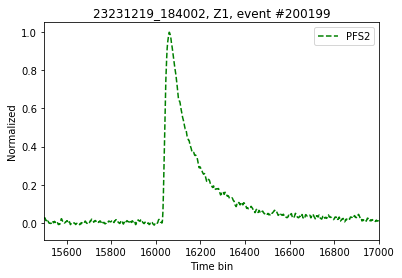

In [23]:

idx = 0
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
#     if(c=='PT'):
#         continue
    if(c!='PB'):
         continue

    if(det == 'Z3' and c == 'PAS1'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    #lp_filtered = (bs_corrected)
    print(max(lp_filtered))
    lp_filtered = lp_filtered/max(lp_filtered)
    plt.plot((lp_filtered),label=c,color=color_p[c],linestyle=style_p[c])
    plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))
plt.legend()
plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('Normalized')
plt.xlabel('Time bin')
#plt.ylim(-0.02,0.14)
plt.show()

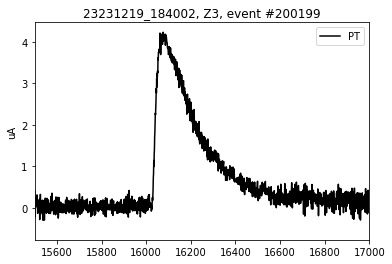

In [117]:

idx = 2
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
    if(c!='PT'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    #lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    lp_filtered = (bs_corrected)
    
    plt.plot((lp_filtered)*1e6,label=c,color=color_p[c],linestyle=style_p[c])
    plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))
plt.legend()
plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
#plt.ylim(-0.02,0.14)
plt.show()

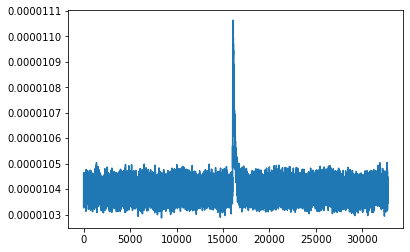

In [33]:
plt.plot(data['23231219_184002']['PBS1'][0])

In [40]:
raw_data['23231219_184002']['PBS1'][idx]['event']['EventNumber']

152887

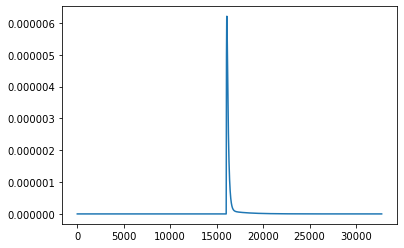

In [82]:
plt.plot(template_ss['23231219_184002']['PT'][2])


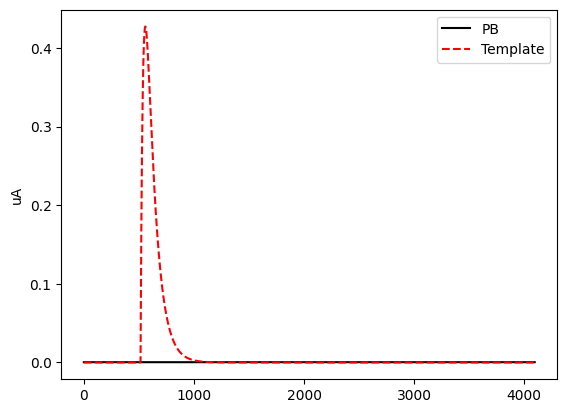

In [77]:
idx = 0
key = series[0]
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
c = 'PB'
bs_corrected = traces_ped_sub[key][c][idx]
lp_filtered = (bs_corrected)
temp = template_ss[key][c][idx]
plt.plot((lp_filtered)*1e6,label=c,color='black',linestyle='-')
plt.plot((temp)*1e6,color='red',linestyle='--',label='Template')
#plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))

plt.legend()
#plt.xlim(15500,18000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
#plt.ylim(-0.02,0.14)
plt.show()

In [126]:
'''
    Save tra
'''
key = series[0]
save=True
for idx in range(len(event_numbers)):
    for c in channels:
        if(det=='Z3' and c == 'PAS1'):
            continue
        #plt.ioff()
        plt.figure()
        
        bs_corrected = traces_ped_sub[key][c][idx]
        lp_filtered = (bs_corrected)
        temp = template_ss[key][c][idx]
        plt.plot((lp_filtered)*1e6,label=c,color='black',linestyle='-')
        plt.plot((temp)*1e6,color='red',linestyle='--',label='Template')
        plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))

        plt.legend()
        plt.xlim(15500,18000)
        plt.ylabel('uA')
        #plt.show()
        savename = './plots/traces/%s/Event%d/%s.png'%(det,idx,c)
        if(save):
            plt.savefig(savename)
            print(savename)
        plt.close()
        


./plots/traces/Z1/Event0/PT.png
./plots/traces/Z1/Event0/PAS1.png
./plots/traces/Z1/Event0/PBS1.png
./plots/traces/Z1/Event0/PCS1.png
./plots/traces/Z1/Event0/PDS1.png
./plots/traces/Z1/Event0/PES1.png
./plots/traces/Z1/Event0/PFS1.png
./plots/traces/Z1/Event0/PAS2.png
./plots/traces/Z1/Event0/PBS2.png
./plots/traces/Z1/Event0/PCS2.png
./plots/traces/Z1/Event0/PDS2.png
./plots/traces/Z1/Event0/PES2.png
./plots/traces/Z1/Event0/PFS2.png
./plots/traces/Z1/Event1/PT.png
./plots/traces/Z1/Event1/PAS1.png
./plots/traces/Z1/Event1/PBS1.png
./plots/traces/Z1/Event1/PCS1.png
./plots/traces/Z1/Event1/PDS1.png
./plots/traces/Z1/Event1/PES1.png
./plots/traces/Z1/Event1/PFS1.png
./plots/traces/Z1/Event1/PAS2.png
./plots/traces/Z1/Event1/PBS2.png
./plots/traces/Z1/Event1/PCS2.png
./plots/traces/Z1/Event1/PDS2.png
./plots/traces/Z1/Event1/PES2.png
./plots/traces/Z1/Event1/PFS2.png
./plots/traces/Z1/Event2/PT.png
./plots/traces/Z1/Event2/PAS1.png
./plots/traces/Z1/Event2/PBS1.png
./plots/traces/Z1/Ev